In [2]:
from scipy.io import wavfile
import numpy as np
import sounddevice as sd
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fft import fftshift
import sys

sys.path.append('/Users/kevinbrennan/Desktop/Final Project/Python Tests/Reverb (Python)/Comb Filter Reverberator')

#KYW inst
fs, data = wavfile.read('/Users/kevinbrennan/Desktop/Final Project/Music-Technology-Final-Project/Sound Examples/KYW Inst.wav')
#ATF Drums
#fs, data = wavfile.read('/Users/kevinbrennan/Desktop/Final Project/Music-Technology-Final-Project/Sound Examples/Around the fur drums.wav')

# Get the bit depth of the audio data (assumes audio_data is a NumPy array)
bit_depth = data.dtype.itemsize * 8

# Calculate the scaling factor for normalization
scaling_factor = 2 ** (bit_depth - 1)  # For signed audio

# Convert audio data to floating-point values and normalize
data = data.astype(np.float32) / scaling_factor

# Verify that the data is now in the range -1 to 1
print(f"Min Value: {np.min(data)}")
print(f"Max Value: {np.max(data)}")

Min Value: -0.9484677314758301
Max Value: 0.9998999834060669


In [3]:
# Variables
corner_freq = 1000

bandwidth = 0.2 #in octaves


w0 = 2 * np.pi * (corner_freq/fs)

cos_w0 = np.cos(w0)

sin_w0 = np.sin(w0)

alpha = (sin_w0) * np.sinh((np.log(2)/2) * bandwidth * (w0/sin_w0))

In [4]:
# Second order Band Pass Filter (Constant 0dB peak gain, no Q control) - W3

# Coefficients

b0 = alpha
b1 = 0
b2 = -alpha
a0 = 1 + alpha
a1 = -2 * cos_w0
a2 = 1 - alpha

num = [b0, b1, b2]
den = [a0, a1, a2]

w, H = signal.freqz(num, den)

In [5]:
# Second order Band Pass Filter (Constant skirt gain, peak gain = Q) - W3

#Variables
Q = 3

alpha_Q = (sin_w0/(2 * Q))

# Coefficients
b0_q = Q * alpha_Q
b1_q = 0
b2_q = -Q * alpha_Q
a0_q = 1 + alpha_Q
a1_q = -2 * cos_w0
a2_q = 1 - alpha_Q


num_q = [b0_q, b1_q, b2_q]
den_q = [a0_q, a1_q, a2_q]

w_q, H_q = signal.freqz(num_q, den_q)

In [6]:
# Butterworth implementation (2 pole)

start_stop = [corner_freq - 100, corner_freq + 100]

b_2, a_2 = signal.butter(2, start_stop, 'bandpass', fs=fs)

w_2, H_2 = signal.freqz(b_2, a_2)

In [7]:
# Butterworth implementation (3 pole)

b_3, a_3 = signal.butter(3, start_stop, 'bandpass', fs=fs)

w_3, H_3 = signal.freqz(b_3, a_3)

/var/folders/wl/6gyc0yz53snb8mbsbvf6rnh80000gn/T/ipykernel_55314/11022499.py:21: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim([0, fs/2])  # Set x-axis limits
/var/folders/wl/6gyc0yz53snb8mbsbvf6rnh80000gn/T/ipykernel_55314/11022499.py:36: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim([0, fs/2])  # Set x-axis limits


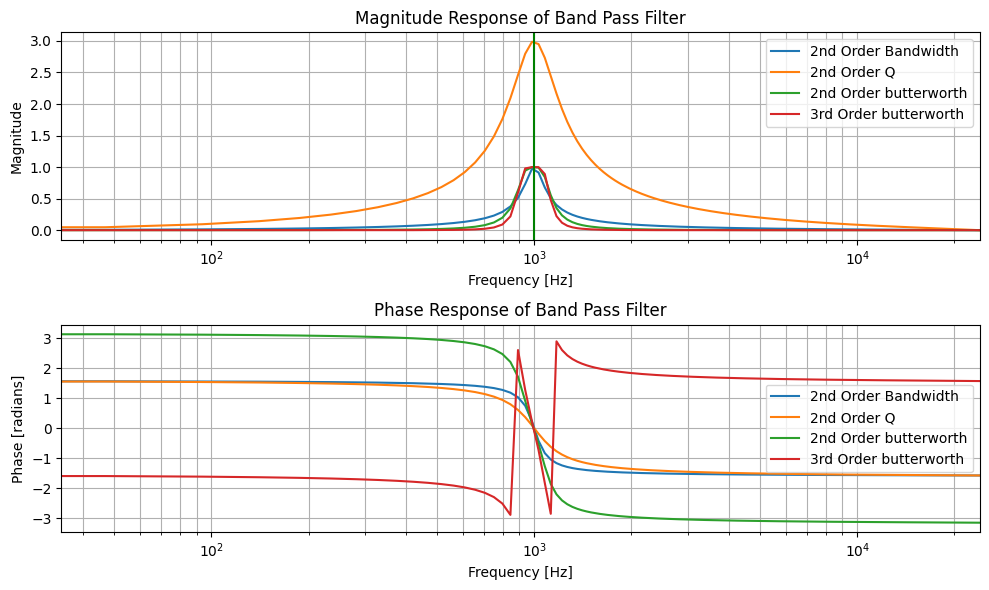

In [8]:
freq_hz_2p = w * (fs / (2 * np.pi))

freq_hz_2pq = w_q * (fs / (2 * np.pi))

freq_hz_2p_butt = w_2 * (fs / (2 * np.pi))

freq_hz_3p_butt = w_3 * (fs / (2 * np.pi))

# Plot magnitude and phase responses in Hz
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(freq_hz_2p, np.abs(H), label='2nd Order Bandwidth')
plt.plot(freq_hz_2pq, np.abs(H_q), label='2nd Order Q')
plt.plot(freq_hz_2p_butt, np.abs(H_2), label='2nd Order butterworth')
plt.plot(freq_hz_3p_butt, np.abs(H_3), label='3rd Order butterworth')
plt.title('Magnitude Response of Band Pass Filter')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.grid(which='both')
plt.xscale('log')  # Set x-axis to a logarithmic scale
plt.xlim([0, fs/2])  # Set x-axis limits
plt.axvline(corner_freq, color='green')
plt.legend()


plt.subplot(2, 1, 2)
plt.plot(freq_hz_2p, np.angle(H), label='2nd Order Bandwidth')
plt.plot(freq_hz_2pq, np.angle(H_q), label='2nd Order Q')
plt.plot(freq_hz_2p_butt, np.angle(H_2), label='2nd Order butterworth')
plt.plot(freq_hz_3p_butt, np.angle(H_3), label='3rd Order butterworth')
plt.title('Phase Response of Band Pass Filter')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Phase [radians]')
plt.grid(which='both')
plt.xscale('log')  # Set x-axis to a logarithmic scale
plt.xlim([0, fs/2])  # Set x-axis limits
plt.legend()


plt.tight_layout()
plt.show()

In [13]:
### Filtering Data ###
b = num_q
a = den_q

data_filtL = signal.lfilter(b, a, data[:,0])
data_filtR = signal.lfilter(b, a, data[:,1])

stereoFiltered = np.vstack((data_filtL, data_filtR))
stereoFiltered = np.transpose(stereoFiltered) 

sd.play(stereoFiltered, fs)